In [305]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

# 파일 경로
model_paths = os.listdir("모델 예측 결과를 저장해둔 폴더주소")
submission_path = "sample_submission.csv"

# 파일 컨테이너 변수 정의
dataframes = [pd.read_csv(path) for path in model_paths ]

# Score 
scores = [float(path.split('_')[-1][:-4]) for path in model_paths]

# based in (score)
scores_f1 = [score/100 for score in scores]

# softmax(score)
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # for numerical stability
    return exp_x / exp_x.sum(axis=0)
scores_soft = softmax(scores).tolist()

# num2label 파일 로드
num2label = "dict_num_to_label.pkl"
with open(num2label, "rb") as f:
    n2l = pickle.load(f)


# onehot-scaling
def onehot(*data):
        onehot = [np.array(data)==max(x) for x in data]
        return onehot


def soft_vote(dataframes):
    probs = []
    for i in range(len(dataframes)):
        prob_raw = dataframes[i]['probs']
        prob = [eval(pb) for pb in prob_raw]
        probs.append(prob)

    probs = np.array(probs)
    probs = np.mean(probs, axis=0)

    # 담을 때, 리스트로 담아야 matrix 보존가능
    output = pd.read_csv(submission_path)
    output['probs'] = probs.tolist()                                                        # axis = 0 ; 모델 차원
    output['pred_label'] = [n2l[label] for label in np.argmax(probs, axis = 1)]             # axis = 1 ; class 차원

    plt.figure(figsize=(10,15))
    sns.countplot(data=output, y ='pred_label', order=
                  output['pred_label'].value_counts().index)
    output.to_csv('Average_soft_output.csv', index=False)
    print("Average soft voting의 output이 생성되었습니다.")


def hard_vote(dataframes):
    probs = []
    probs_oh = []
    for i in range(len(dataframes)):
        prob_raw = dataframes[i]['probs']

        prob = [eval(pb) for pb in prob_raw]
        prob_oh = [onehot(eval(pb)) for pb in prob_raw]
        
        probs_oh.append(prob_oh)
        probs.append(prob)

    probs = np.array(probs)
    probs = np.mean(probs, axis=0)
    
    probs_oh = np.array(probs_oh)
    temp = np.mean(probs_oh, axis=0, dtype=float).reshape(-1,30) # 확률(~빈도)
    
    # 담을 때, 리스트로 담아야 matrix 보존가능
    output = pd.read_csv(submission_path)
    output['probs'] = probs.tolist()                                               # axis = 0 ; 모델 차원
    output['pred_label'] = [n2l[label] for label in np.argmax(temp, axis = 1)]     # axis = 1 ; class 차원

    plt.figure(figsize=(10,15))
    sns.countplot(data=output, y ='pred_label', order=
                  output['pred_label'].value_counts().index)
    output.to_csv('Average_hard_output.csv', index=False)
    print("Average hard voting의 output이 생성되었습니다.")


def weight_soft_vote(dataframes, style=scores_f1):
    scores = style
    probs = []
    for i in range(len(dataframes)):
        prob_raw = dataframes[i]['probs']
        prob = scores[i]*np.array([eval(pb) for pb in prob_raw])
        probs.append(prob)

    probs = np.array(probs)
    if scores==scores_f1:
        probs = np.mean(probs, axis=0)
    elif scores==scores_soft:
        probs = np.sum(probs, axis=0)
    
    # 담을 때, 리스트로 담아야 matrix 보존가능
    output = pd.read_csv(submission_path)
    output['probs'] = probs.tolist()       
    output['pred_label'] = [n2l[label] for label in np.argmax(probs, axis = 1)]             # axis = 1 ; class 차원
    
    plt.figure(figsize=(10,15))
    sns.countplot(data=output, y ='pred_label', order=
                  output['pred_label'].value_counts().index)                                                 # axis = 0 ; 모델 차원
    output.to_csv('Weighted_soft_output.csv', index=False)
    print("Weighted soft voting의 output이 생성되었습니다.")


def weight_hard_vote(dataframes, style=scores_f1):
    scores = style
    probs = []
    probs_oh = []
    for i in range(len(dataframes)):
        prob_raw = dataframes[i]['probs']

        prob = scores[i]*np.array([eval(pb) for pb in prob_raw])
        prob_oh = scores[i]*np.array([onehot(eval(pb)) for pb in prob_raw])
        
        probs_oh.append(prob_oh)
        probs.append(prob)

    probs = np.array(probs)
    if scores==scores_f1:
        probs = np.mean(probs, axis=0)
    elif scores==scores_soft:
        probs = np.sum(probs, axis=0)
    
    probs_oh = np.array(probs_oh)
    temp = np.sum(probs_oh, axis=0, dtype=float).reshape(-1,30) # 확률(~빈도)
    
    # 담을 때, 리스트로 담아야 matrix 보존가능
    output = pd.read_csv(submission_path)
    output['probs'] = probs.tolist()                                               # axis = 0 ; 모델 차원
    output['pred_label'] = [n2l[label] for label in np.argmax(temp, axis = 1)]     # axis = 1 ; class 차원

    plt.figure(figsize=(10,15))
    sns.countplot(data=output, y ='pred_label', order=
                  output['pred_label'].value_counts().index)
    output.to_csv('Weighted_hard_output.csv', index=False)
    print("Weighted hard voting의 output이 생성되었습니다.")



Weighted hard voting의 output이 생성되었습니다.


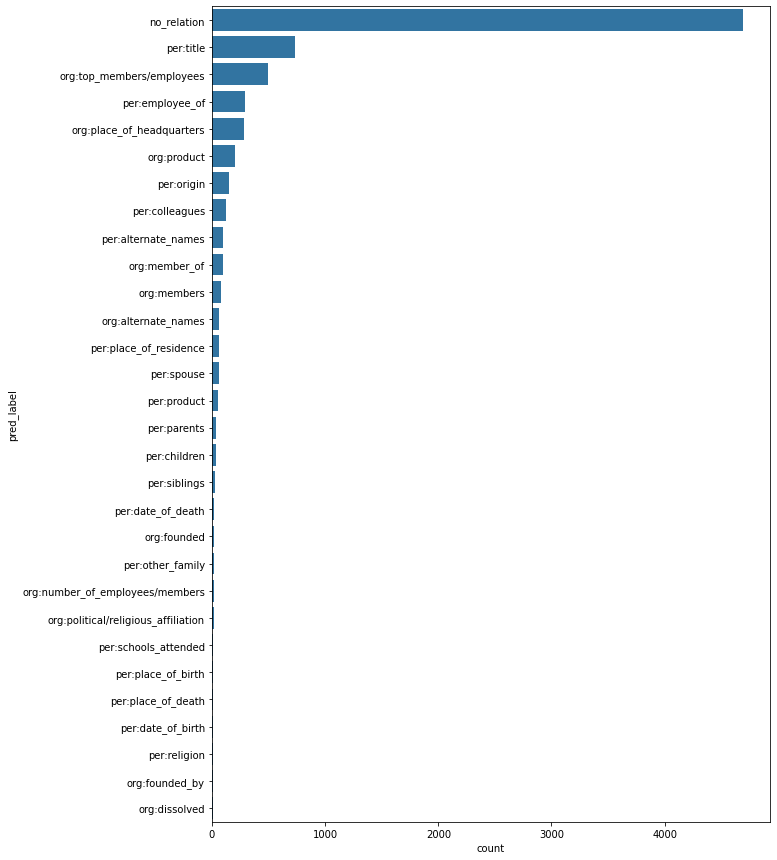

In [306]:
weight_hard_vote(dataframes, style=scores_soft)

Average hard voting의 output이 생성되었습니다.


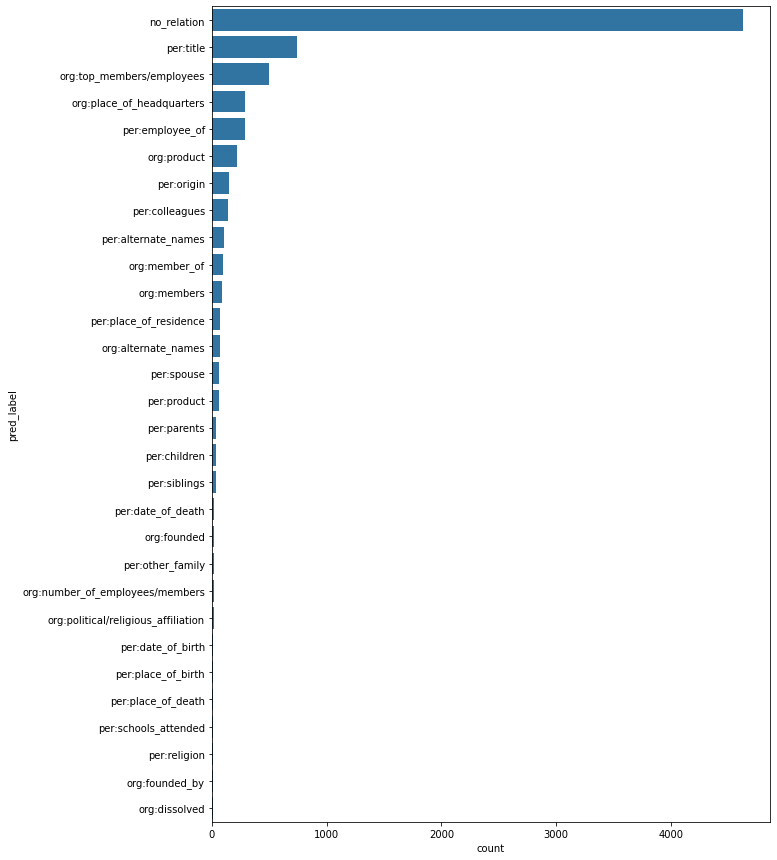

In [307]:
hard_vote(dataframes)

Weighted soft voting의 output이 생성되었습니다.


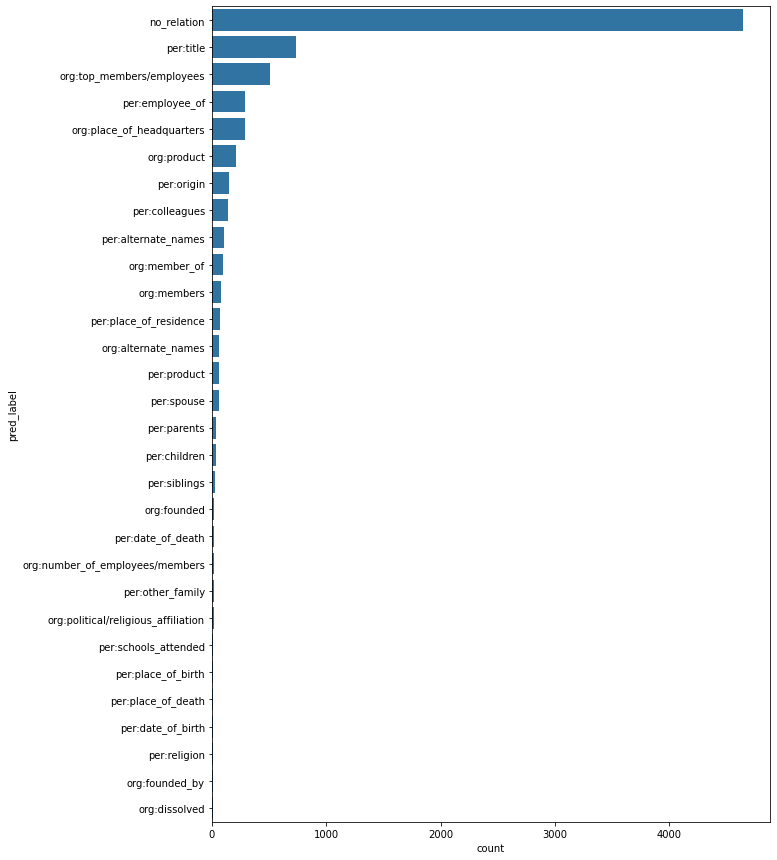

In [308]:
weight_soft_vote(dataframes, style=scores_soft)

Average soft voting의 output이 생성되었습니다.


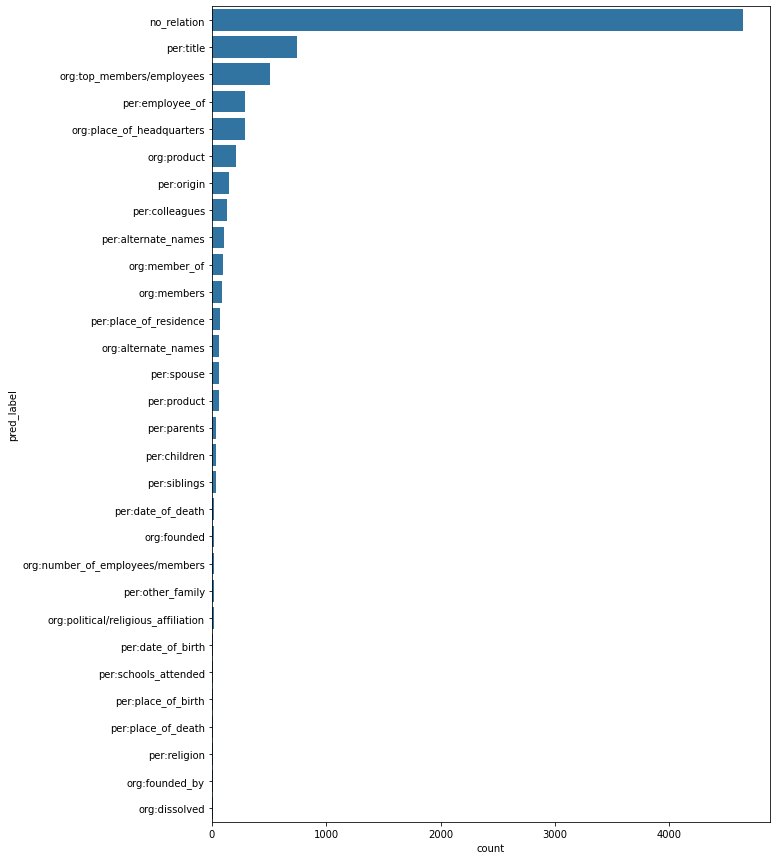

In [309]:
soft_vote(dataframes)

In [310]:
model_paths

['hfl_cino-large-v2_typed_punct_marker_submission_68.1797.csv',
 'wooy0ng_korquad1-klue-roberta-large_typed_punct_marker_submission_71.7003.csv',
 'studio-ousia_mluke-large-lite_typed_punct_marker_submission_69.321.csv',
 'google_rembert_type_punct_prompt_submission_67.3201.csv',
 'output(38)_75.6076.csv',
 'output(45)_82.1016.csv',
 'output(42)_77.9499.csv',
 'output(44)_81.9871.csv',
 'output(40)_78.9868.csv']